# 2010년대 미국의 금융 데이터셋 분석과 소비 트렌드 예측

## 주제
**"소비 패턴과 소득 간의 관계를 분석하고, 소비 트렌드를 예측할 수 있는가?"**

---

## 분석 목표 및 질문
- **데이터 출처**: [Kaggle 데이터셋](https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets)을 사용하여 미국의 2010년대 금융 거래 데이터 분석.

1. **소비 트렌드를 예측할 수 있는가?**
   - 월별 소비 데이터를 분석하고, 미래 소비 변화를 예측하기 위한 머신러닝 모델(Random Forest Regressor) 학습.
   
2. **소득과 소비 간의 관계는 무엇인가?**
   - 사용자 소득(`per_capita_income`, `yearly_income`)과 소비 금액 간의 상관관계를 분석.
   - 소득 수준별로 소비 패턴의 차이를 파악.

3. **데이터 전처리를 통해 정확한 분석과 모델링이 가능한가?**
   - 데이터 품질을 개선하여 신뢰할 수 있는 분석 결과와 머신러닝 모델을 도출.


# 분석과정

## 1. 데이터 준비 및 로드

- **Google Drive 마운트**: Google Colab 환경에서 데이터를 불러오기 위해 Google Drive를 마운트.
- **데이터 불러오기**:
  - `transactions_data.csv`: 소비 데이터.
  - `mcc_codes.json`: 업종(MCC) 코드 데이터.
  - `users_data.csv`: 사용자 프로필 데이터(소득, 부채 등).

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 필요 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import json

In [3]:
# 파일 경로 설정
base_path = '/content/drive/My Drive/BigData/'
transactions_file = base_path + 'transactions_data.csv'
mcc_codes_file = base_path + 'mcc_codes.json'
users_file = base_path + 'users_data.csv'

In [4]:
# Transaction 데이터 불러오기
transactions = pd.read_csv(transactions_file)

# Transaction 데이터 확인
print("Transactions 데이터:\n", transactions.head())

Transactions 데이터:
         id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475331  2010-01-01 00:05:00        430     2860  $200.00   
4  7475332  2010-01-01 00:06:00        848     3915   $46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


In [5]:
# JSON 파일 읽기 및 변환
with open(mcc_codes_file, 'r') as f:
    mcc_codes_data = json.load(f)

# JSON 데이터 확인 및 변환
if isinstance(mcc_codes_data, dict):  # JSON 데이터가 딕셔너리인 경우
    mcc_codes = pd.DataFrame(list(mcc_codes_data.items()), columns=['mcc', 'description'])
elif isinstance(mcc_codes_data, list):  # JSON 데이터가 리스트인 경우
    mcc_codes = pd.DataFrame(mcc_codes, columns=['mcc', 'description'])
else:
    print("Unsupported JSON data type.")
    mcc_codes = pd.DataFrame()  # 비어있는 DataFrame 생성

# 데이터 확인
print("MCC Codes 데이터 변환 후:\n", mcc_codes.head())

MCC Codes 데이터 변환 후:
     mcc                           description
0  5812         Eating Places and Restaurants
1  5541                      Service Stations
2  7996  Amusement Parks, Carnivals, Circuses
3  5411          Grocery Stores, Supermarkets
4  4784                 Tolls and Bridge Fees


In [6]:
# Users 데이터 불러오기
users = pd.read_csv(users_file)

# Users데이터 확인
print("Users 데이터:\n", users.head())

Users 데이터:
      id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   

                    address  latitude  longitude per_capita_income  \
0             462 Rose Lane     34.15    -117.76            $29278   
1    3606 Federal Boulevard     40.76     -73.74            $37891   
2           766 Third Drive     34.02    -117.89            $22681   
3          3 Madison Street     40.71     -73.99           $163145   
4  9620 Valley Stream Drive     37.76    -122.44            $53797   

  yearly_income total_debt  credit_score  num_credit_cards  
0        $59696    $127613           787                 5  
1     

#2. 데이터 전처리

### 1. 금액 데이터에서 `$`와 `,` 제거 후 숫자로 변환
- 문자열 형식(`$1,234.56`)으로 저장된 금액 데이터를 숫자 형식(`1234.56`)으로 변환하여 계산 및 머신러닝 모델 입력으로 사용할 수 있도록 함.

### 2. `per_capita_income`와 `yearly_income` 열 처리
- 소득 데이터(`$45,678.00`)를 숫자 형식으로 변환하여 지역별 소비와 소득 간의 관계 분석, 머신러닝 모델 입력으로 활용 가능하게 함.

### 3. `total_debt` 열에서 `$`와 `,` 제거 후 숫자 변환
- 부채 데이터(`$123,456.00`)를 숫자 형식으로 변환하여 부채와 소비 간의 관계 분석 및 머신러닝 모델 입력 변수로 사용 가능하게 함.

In [7]:
# 'amount' 열에서 '$'와 ',' 제거 후 숫자 변환
transactions['amount'] = transactions['amount'].replace('[\$,]', '', regex=True).astype(float)

# 'per_capita_income'와 'yearly_income' 열 처리
users['per_capita_income'] = users['per_capita_income'].replace('[\$,]', '', regex=True).astype(float)
users['yearly_income'] = users['yearly_income'].replace('[\$,]', '', regex=True).astype(float)

# 'total_debt' 열에서 '$'와 ',' 제거 후 숫자 변환
users['total_debt'] = users['total_debt'].replace('[\$,]', '', regex=True).astype(float)

##**`transactions`와 `mcc_codes`의 병합 이유**:
  - `mcc`를 기준으로 `transactions` 데이터에 `description` 열(업종 설명)을 추가하여 업종별 소비 분석이 가능하게 함.

### 1. 데이터 타입 확인
- 병합 가능한지 확인하기 위해 `transactions`와 `mcc_codes`의 `mcc` 열 데이터 타입 점검.

### 2. 데이터 타입 변환
- `mcc` 열의 데이터 타입을 일치시켜 병합 오류를 방지.

### 3. 병합 시도
- `mcc`를 기준으로 병합하여 `transactions` 데이터에 업종 설명(`description`) 추가.

### 4. 병합 결과 확인
- 병합 성공 여부와 데이터에 `description` 열이 추가되었는지 확인.

In [8]:
# 데이터 타입 확인
print("Transactions mcc dtype:", transactions['mcc'].dtype)
print("MCC Codes mcc dtype:", mcc_codes['mcc'].dtype)

# 데이터 타입 변환
transactions['mcc'] = transactions['mcc'].astype(int)
mcc_codes['mcc'] = mcc_codes['mcc'].astype(int)

# 병합 시도
try:
    transactions = transactions.merge(mcc_codes, on='mcc', how='left')
    print("MCC Codes successfully merged with Transactions.")
except Exception as e:
    print(f"Error during merging MCC Codes: {e}")

# 병합 결과 확인
print("Transactions 데이터 병합 후:\n", transactions.head())

Transactions mcc dtype: int64
MCC Codes mcc dtype: object
MCC Codes successfully merged with Transactions.
Transactions 데이터 병합 후:
         id                 date  client_id  card_id  amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  -77.00   
1  7475328  2010-01-01 00:02:00        561     4575   14.57   
2  7475329  2010-01-01 00:02:00       1129      102   80.00   
3  7475331  2010-01-01 00:05:00        430     2860  200.00   
4  7475332  2010-01-01 00:06:00        848     3915   46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  e

## 환불 데이터를 별도로 처리하는 이유

### 1. 환불 데이터를 구분하기 위함
- `amount`가 음수인 거래는 환불을 의미하므로, 이를 구분하여 별도의 데이터로 분리.

### 2. 분석의 명확성을 높이기 위함
- 환불 데이터를 포함한 분석은 소비 패턴을 왜곡할 수 있으므로, 환불 데이터를 제외한 후 소비 분석을 진행.

### 3. 환불 데이터만을 분석하기 위함
- 환불 데이터는 특정 업종이나 지역에서의 문제점을 파악하거나, 환불 비율이 높은 패턴을 분석하는 데 활용 가능.


In [9]:
# 환불 데이터를 별도 처리
refunds = transactions[transactions['amount'] < 0]
transactions = transactions[transactions['amount'] >= 0]
print(f"환불 데이터 수: {len(refunds)}")
print("환불 데이터 샘플:\n", refunds.head())

환불 데이터 수: 660049
환불 데이터 샘플:
           id                 date  client_id  card_id  amount  \
0    7475327  2010-01-01 00:01:00       1556     2972   -77.0   
19   7475347  2010-01-01 00:36:00        114     3398   -64.0   
50   7475382  2010-01-01 01:25:00       1703     2969   -78.0   
81   7475422  2010-01-01 02:13:00       1453     1117  -460.0   
114  7475460  2010-01-01 03:08:00        957     4532  -147.0   

              use_chip  merchant_id    merchant_city merchant_state      zip  \
0    Swipe Transaction        59935           Beulah             ND  58523.0   
19   Swipe Transaction        61195  North Hollywood             CA  91606.0   
50   Swipe Transaction        43293   Grand Junction             CO  81506.0   
81   Swipe Transaction         5009       Middletown             NY  10940.0   
114  Swipe Transaction        44795       Marysville             OH  43040.0   

      mcc errors                        description  
0    5499    NaN          Miscellaneous Food 

#3. 데이터 분석 및 시각화

##3.1 지역별 소비 금액 및 거래 빈도 집계

Top Spending Regions:
        merchant_city merchant_state  total_amount  transaction_count  \
7833         Houston             TX    7512355.86             135838   
9123       Las Vegas             NV    4496008.71              45794   
12256        Oakland             CA    4166601.29              36502   
10700          Miami             FL    3819997.40              81442   
14847  San Francisco             CA    3520615.38              43582   
9720     Los Angeles             CA    3360006.39              78433   
10598        Memphis             TN    3236570.20              40032   
675          Atlanta             GA    3195722.55              48804   
4051          Dallas             TX    3130250.73              65929   
2001        Brooklyn             NY    3063290.21              78560   

       avg_transaction  
7833         55.303787  
9123         98.178991  
12256       114.147205  
10700        46.904514  
14847        80.781409  
9720         42.839193  
10598    

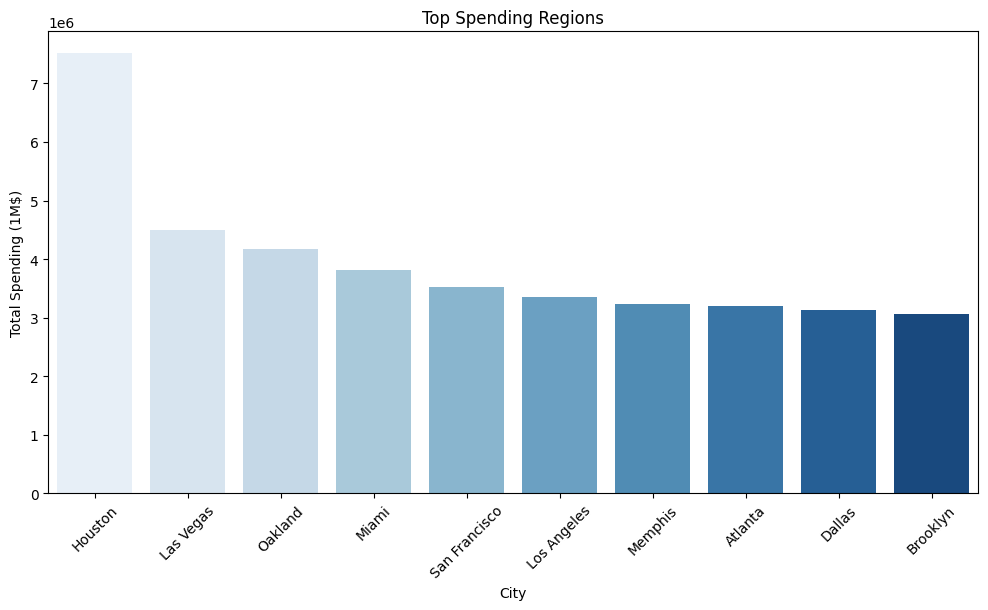

In [10]:
# 지역별 소비 금액 및 거래 빈도 집계
region_summary = transactions.groupby(['merchant_city', 'merchant_state']).agg(
    total_amount=('amount', 'sum'),
    transaction_count=('amount', 'count'),
    avg_transaction=('amount', 'mean')
).reset_index()

# 상위 소비 금액 지역
top_regions = region_summary.sort_values(by='total_amount', ascending=False).head(10)
print("Top Spending Regions:\n", top_regions)

# 소비 금액 상위 지역 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=top_regions, x='merchant_city', y='total_amount', palette='Blues', hue='merchant_city', dodge=False)
plt.title('Top Spending Regions')
plt.xlabel('City')
plt.ylabel('Total Spending (1M$)')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # 범례 제거
plt.show()

### 지역별 소비 분석 결과

#### 상위 소비 금액 지역
1. **Houston, TX**  
   - 총 소비 금액: \$7,512,355.86  
   - 거래 건수: 135,838건  
   - 평균 거래 금액: \$55.30  
   - **분석**: 가장 많은 소비가 발생한 도시로, 거래 빈도가 높은 편이나 평균 거래 금액은 상대적으로 낮음. 이는 소규모 거래가 많음을 시사.

2. **Las Vegas, NV**  
   - 총 소비 금액: \$4,496,008.71  
   - 거래 건수: 45,794건  
   - 평균 거래 금액: \$98.18  
   - **분석**: 평균 거래 금액이 높은 편으로, 대규모 소비가 많을 가능성이 있음. 관광지 특성이 반영된 결과일 수 있음.

3. **Oakland, CA**  
   - 총 소비 금액: \$4,166,601.29  
   - 거래 건수: 36,502건  
   - 평균 거래 금액: \$114.15  
   - **분석**: 거래 빈도가 적지만 평균 거래 금액이 매우 높음. 이는 특정 고가 품목의 소비가 집중된 지역일 가능성을 나타냄.

4. **Miami, FL**  
   - 총 소비 금액: \$3,819,997.40  
   - 거래 건수: 81,442건  
   - 평균 거래 금액: \$46.90  
   - **분석**: 거래 빈도가 높은 지역이나 평균 거래 금액은 낮음. 이는 중저가 품목 소비가 주를 이룰 가능성을 의미.

5. **San Francisco, CA**  
   - 총 소비 금액: \$3,520,615.38  
   - 거래 건수: 43,582건  
   - 평균 거래 금액: \$80.78  
   - **분석**: 거래 빈도와 평균 거래 금액이 모두 중간 수준으로 안정적인 소비 패턴을 보임.

6. **Los Angeles, CA**  
   - 총 소비 금액: \$3,360,006.39  
   - 거래 건수: 78,433건  
   - 평균 거래 금액: \$42.83  
   - **분석**: 거래 빈도가 높고 평균 거래 금액이 낮음. 일상적인 소비가 주를 이룰 가능성이 큼.

7. **Memphis, TN**  
   - 총 소비 금액: \$3,236,570.20  
   - 거래 건수: 40,032건  
   - 평균 거래 금액: \$80.85  
   - **분석**: 중간 수준의 거래 빈도와 평균 거래 금액으로 안정적인 소비 패턴을 보임.

8. **Atlanta, GA**  
   - 총 소비 금액: \$3,195,722.55  
   - 거래 건수: 48,804건  
   - 평균 거래 금액: \$65.48  
   - **분석**: 거래 빈도가 높은 편이며 평균 거래 금액도 적당함. 다양한 소비 패턴이 혼재된 지역.

9. **Dallas, TX**  
   - 총 소비 금액: \$3,130,250.73  
   - 거래 건수: 65,929건  
   - 평균 거래 금액: \$47.48  
   - **분석**: 거래 빈도가 높으나 평균 거래 금액은 낮음. 중저가 소비가 많은 지역.

10. **Brooklyn, NY**  
    - 총 소비 금액: \$3,063,290.21  
    - 거래 건수: 78,560건  
    - 평균 거래 금액: \$38.99  
    - **분석**: 거래 빈도가 매우 높으나 평균 거래 금액이 낮음. 이는 대량 구매보다는 일상적인 소액 소비가 많은 지역임을 나타냄.

#### 전반적 분석
- **Houston**은 총 소비 금액과 거래 건수 모두에서 가장 높아, 전체 소비의 중심 지역임.  
- **Oakland**는 평균 거래 금액이 가장 높아, 고가 품목 소비가 집중된 지역으로 보임.  
- **Brooklyn**과 **Los Angeles**는 거래 빈도가 매우 높으나 평균 거래 금액이 낮아, 일상적이고 소액 소비가 주를 이룸.  
- **Las Vegas**와 **San Francisco**는 관광객이나 고가 품목 소비로 인한 높은 평균 거래 금액이 특징.

#### 제안
- **Houston**과 **Las Vegas**: 지역 내 소비 트렌드에 맞춘 대규모 프로모션 기획.  
- **Brooklyn**과 **Los Angeles**: 일상 소비품에 대한 할인 캠페인이나 고객 충성도 프로그램 도입.  
- **Oakland**: 고급 소비 품목에 대한 마케팅 강화 및 프리미엄 제품 라인업 확대.



##3.2 업종별 소비 금액 및 거래 빈도 집계

Top Spending Industries:
                                     description  total_amount  \
70                               Money Transfer   53158515.64   
87                             Service Stations   51239755.42   
45                 Grocery Stores, Supermarkets   40970767.06   
106                             Wholesale Clubs   37697568.71   
64                    Miscellaneous Food Stores   37352646.05   
33                   Drug Stores and Pharmacies   35113566.87   
104  Utilities - Electric, Gas, Water, Sanitary   27650053.13   
26                            Department Stores   27031990.66   
34                Eating Places and Restaurants   26348245.60   
8                      Automotive Service Shops   24955655.29   

     transaction_count  
70              589140  
87             1135639  
45             1592561  
106             601934  
64             1170332  
33              772898  
104             242990  
26              475376  
34              999727  
8       

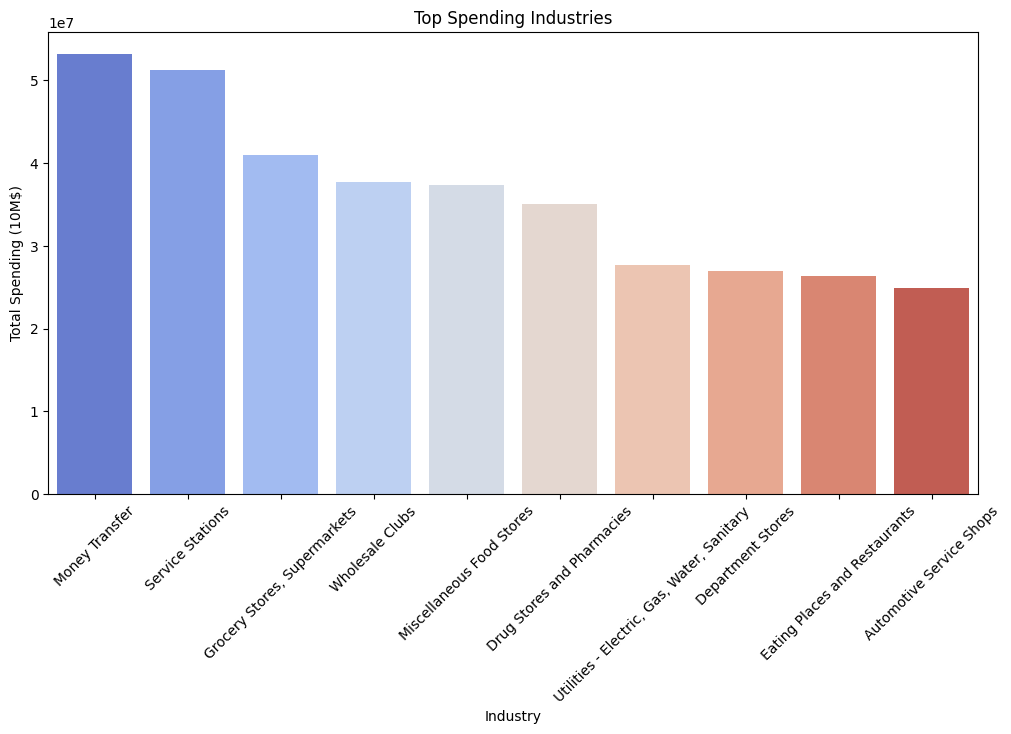

In [11]:
# 업종별 소비 금액 및 거래 빈도 집계
industry_summary = transactions.groupby('description').agg(
    total_amount=('amount', 'sum'),
    transaction_count=('amount', 'count')
).reset_index()

# 소비 금액 상위 10개 업종
top_industries = industry_summary.sort_values(by='total_amount', ascending=False).head(10)
print("Top Spending Industries:\n", top_industries)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_industries, x='description', y='total_amount', palette='coolwarm', hue='description', dodge=False)
plt.title('Top Spending Industries')
plt.xlabel('Industry')
plt.ylabel('Total Spending (10M$)')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)
plt.show()

### 업종별 소비 분석 결과

#### 상위 소비 금액 업종
1. **Money Transfer**  
   - 총 소비 금액: \$53,158,515.64  
   - 거래 건수: 589,140건  
   - **분석**: 금융 관련 소비가 가장 높은 업종으로, 주로 송금 및 금융 서비스에 집중된 소비 패턴을 보여줌.

2. **Service Stations**  
   - 총 소비 금액: \$51,239,755.42  
   - 거래 건수: 1,135,639건  
   - **분석**: 거래 건수가 매우 많으며, 이는 자동차 연료 및 관련 서비스에 대한 높은 수요를 반영.

3. **Grocery Stores, Supermarkets**  
   - 총 소비 금액: \$40,970,767.06  
   - 거래 건수: 1,592,561건  
   - **분석**: 필수 소비재 구매가 많은 업종으로, 가장 많은 거래 건수를 기록.

4. **Wholesale Clubs**  
   - 총 소비 금액: \$37,697,568.71  
   - 거래 건수: 601,934건  
   - **분석**: 대량 구매를 주로 하는 고객층이 집중된 업종으로, 단위 소비 금액이 높은 편.

5. **Miscellaneous Food Stores**  
   - 총 소비 금액: \$37,352,646.05  
   - 거래 건수: 1,170,332건  
   - **분석**: 다양한 식료품을 취급하는 업종으로, 필수 소비가 주를 이룸.

6. **Drug Stores and Pharmacies**  
   - 총 소비 금액: \$35,113,566.87  
   - 거래 건수: 772,898건  
   - **분석**: 의료 및 의약품 관련 소비가 높은 업종으로, 건강 관리와 직결된 소비 패턴을 나타냄.

7. **Utilities - Electric, Gas, Water, Sanitary**  
   - 총 소비 금액: \$27,650,053.13  
   - 거래 건수: 242,990건  
   - **분석**: 전기, 가스, 수도 등 공공서비스에 대한 소비로, 거래 건수는 적지만 금액은 높은 편.

8. **Department Stores**  
   - 총 소비 금액: \$27,031,990.66  
   - 거래 건수: 475,376건  
   - **분석**: 다양한 제품군을 취급하는 대형 소매점에서 발생한 소비로, 중간 수준의 거래 건수와 금액을 기록.

9. **Eating Places and Restaurants**  
   - 총 소비 금액: \$26,348,245.60  
   - 거래 건수: 999,727건  
   - **분석**: 외식 관련 소비가 높은 업종으로, 평균 거래 금액은 비교적 낮은 편.

10. **Automotive Service Shops**  
    - 총 소비 금액: \$24,955,655.29  
    - 거래 건수: 478,257건  
    - **분석**: 자동차 정비 및 수리에 대한 소비가 주를 이루며, 특정 고객층에 집중된 패턴을 보여줌.

#### 전반적 분석
- **Money Transfer**와 **Service Stations**는 가장 높은 소비 금액을 기록하며, 금융 서비스와 자동차 관련 소비가 전체에서 큰 비중을 차지.  
- **Grocery Stores, Supermarkets**는 거래 건수가 압도적으로 많아 필수 소비재에 대한 높은 수요를 보여줌.  
- **Utilities**와 **Automotive Service Shops**는 거래 건수는 낮으나 상대적으로 높은 단위 소비 금액을 기록, 특정 필수 서비스에 집중된 소비 패턴을 나타냄.

#### 제안
- **Money Transfer**: 금융 서비스와 관련된 추가 상품이나 보너스 프로그램 제공.  
- **Grocery Stores**: 구매 빈도가 높은 고객층을 대상으로 로열티 프로그램 강화.  
- **Utilities**: 스마트 기술과 연계된 추가 서비스 제공으로 소비자 만족도 증대.  
- **Eating Places**: 외식 업계에서 특정 시간대 할인 프로모션으로 소비 유도.


##3.3 월별 소비 금액 집계

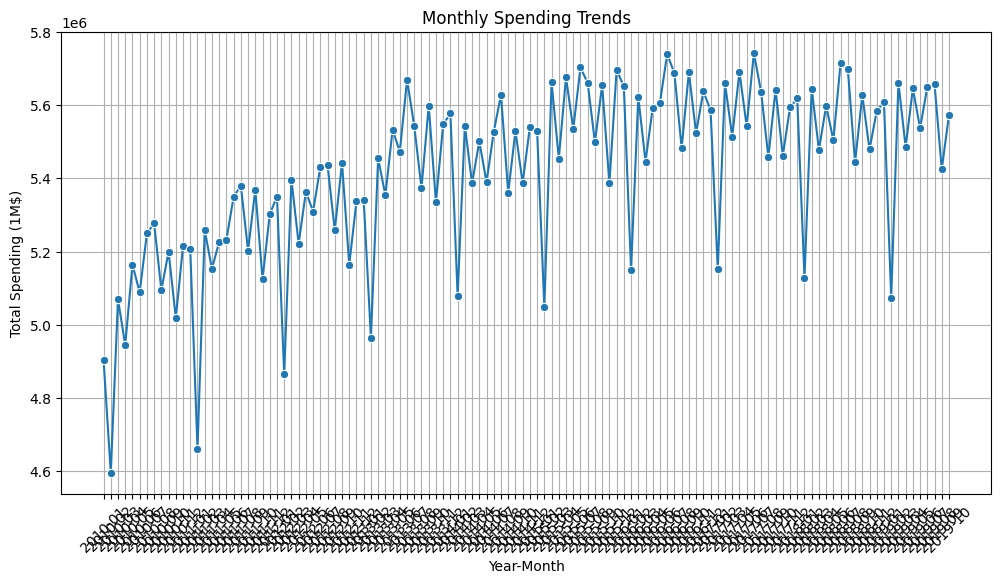

In [12]:
# 거래 날짜를 datetime 형식으로 변환하고 연-월 파생 변수 생성
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['year_month'] = transactions['date'].dt.to_period('M')

# 월별 소비 금액 집계
monthly_trends = transactions.groupby('year_month')['amount'].sum().reset_index()
monthly_trends['year_month'] = monthly_trends['year_month'].astype(str)

# 월별 소비 금액 변화 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends, x='year_month', y='amount', marker='o')
plt.title('Monthly Spending Trends')
plt.xlabel('Year-Month')
plt.ylabel('Total Spending (1M$)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 월별 소비 금액 분석 결과

#### 주요 관찰
1. **전반적인 증가 추세**  
   - 월별 소비 금액이 전반적으로 증가하는 경향을 보임.
   - 소비 금액의 증가 추세는 시간이 지남에 따라 소비 활성화 또는 경제 성장의 영향을 반영.

2. **주기적 변동**  
   - 소비 금액이 특정 시점에서 주기적으로 감소하거나 급격히 증가하는 패턴이 확인됨.
   - 이는 계절적 요인, 공휴일 또는 특정 이벤트(예: 세일 시즌, 연말 쇼핑)와 관련될 가능성이 높음.

3. **최소값과 최대값의 변동**  
   - 소비 금액의 최저치는 약 \$4.6M 수준에서 시작.  
   - 시간이 지남에 따라 최대치는 \$5.6M 이상으로 꾸준히 상승.

#### 시사점
1. **계절적 마케팅 전략**  
   - 주기적 소비 패턴을 활용하여 소비가 낮은 시기에 프로모션을 집중적으로 운영할 필요.
   - 예: 연초나 소비가 낮은 달에 할인 이벤트 제공.

2. **소비 금액 증가 요인 분석**  
   - 소비 금액의 상승세는 인플레이션, 인구 증가, 구매력 상승 등의 요인과 관련될 가능성이 있음.
   - 추가 분석을 통해 주요 원인을 파악해 효과적인 정책 수립 가능.

3. **데이터 기반 예측 모델 구축 가능성**  
   - 이 데이터를 활용해 미래 소비 금액을 예측하는 머신러닝 모델을 설계할 수 있음.
   - 향후 소비 증가 또는 감소 시점을 미리 예측해 대비 가능.

#### 제안
- **비수기 소비 활성화**: 특정 기간 동안 집중적인 마케팅 및 캠페인 추진.
- **소비 패턴 세분화**: 특정 지역 및 업종별로 월별 소비 금액 변동 요인을 추가 분석.
- **정책 설계**: 소비 증가세를 지원하기 위한 정책, 예를 들어 소득 지원 또는 신규 창업 지원 방안 도입.


##3.4 환불 금액 및 횟수 집계

MCC Codes successfully merged with Refunds.
Refund Summary Columns: Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'description'],
      dtype='object')
Refund Summary Sample:
         id                 date  client_id  card_id  amount  \
0  7475327  2010-01-01 00:01:00       1556     2972   -77.0   
1  7475347  2010-01-01 00:36:00        114     3398   -64.0   
2  7475382  2010-01-01 01:25:00       1703     2969   -78.0   
3  7475422  2010-01-01 02:13:00       1453     1117  -460.0   
4  7475460  2010-01-01 03:08:00        957     4532  -147.0   

            use_chip  merchant_id    merchant_city merchant_state      zip  \
0  Swipe Transaction        59935           Beulah             ND  58523.0   
1  Swipe Transaction        61195  North Hollywood             CA  91606.0   
2  Swipe Transaction        43293   Grand Junction             CO  81506.0   
3  Swipe Transaction    

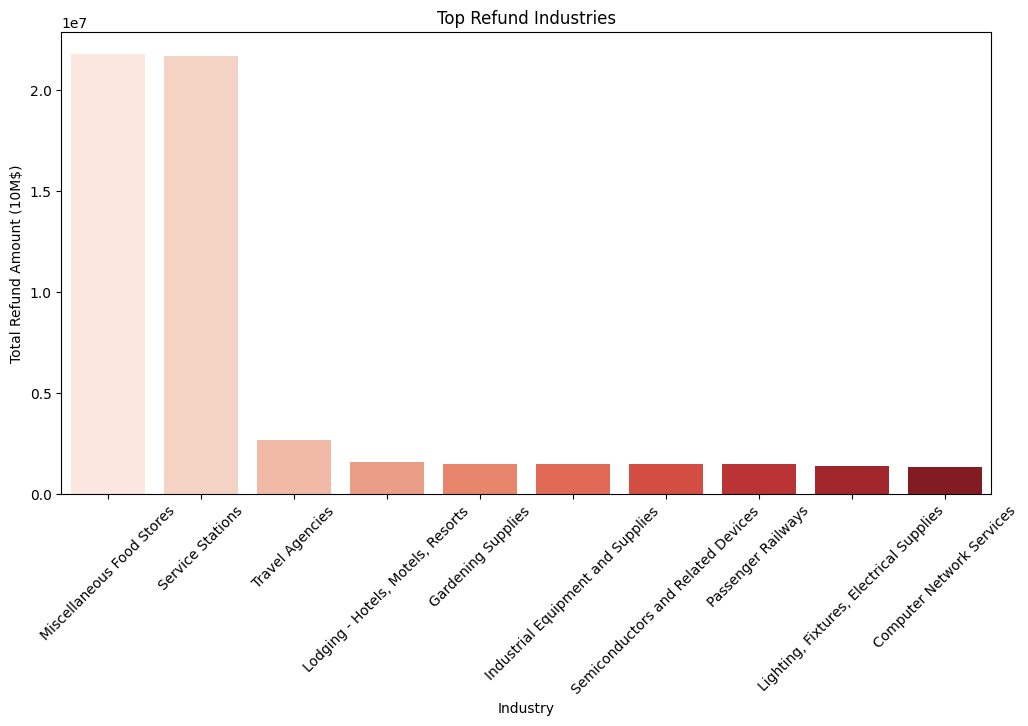

In [13]:
# 환불 데이터에 mcc_codes 데이터 병합 (업종 설명 추가)
try:
    refunds['mcc'] = refunds['mcc'].astype(int)
    mcc_codes['mcc'] = mcc_codes['mcc'].astype(int)
    refund_summary = refunds.merge(mcc_codes, on='mcc', how='left')
    print("MCC Codes successfully merged with Refunds.")
except Exception as e:
    print(f"Error during merging MCC Codes with Refunds: {e}")

# 병합 후 열 이름 정리
refund_summary = refund_summary.rename(columns={'description_y': 'description'})  # description_y를 description으로 변경
refund_summary = refund_summary.drop(columns=['description_x'])  # 필요 없는 description_x 열 삭제

# 병합 후 데이터 확인
print("Refund Summary Columns:", refund_summary.columns)
print("Refund Summary Sample:\n", refund_summary.head())

# 환불 금액 및 환불 횟수 집계
try:
    refund_summary = refund_summary.groupby('description').agg(
        total_refunds=('amount', 'sum'),   # 환불 금액 합계
        refund_count=('amount', 'count')  # 환불 횟수
    ).reset_index()

    # 환불 금액을 절대값으로 변환
    refund_summary['total_refunds'] = refund_summary['total_refunds'].abs()

    # 환불 금액 상위 10개 업종
    top_refund_industries = refund_summary.sort_values(by='total_refunds', ascending=False).head(10)
    print("Top Refund Industries:\n", top_refund_industries)

    # 상위 환불 발생 업종 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_refund_industries, x='description', y='total_refunds', palette='Reds', hue='description', dodge=False)
    plt.title('Top Refund Industries')
    plt.xlabel('Industry')
    plt.ylabel('Total Refund Amount (10M$)')
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)
    plt.show()

except KeyError as e:
    print(f"KeyError: {e}. The column 'description' does not exist.")

### Top Refund Industries Analysis

#### 주요 관찰
1. **상위 2개 업종의 압도적 환불 금액**  
   - `Miscellaneous Food Stores`와 `Service Stations`가 환불 금액의 큰 비중을 차지.  
     - 각각 약 \$21.8M과 \$21.7M의 환불 금액을 기록.
   - 두 업종의 환불 건수도 각각 290,543건과 289,072건으로 매우 높음.
   - 이 두 업종에서 환불 금액과 건수가 압도적으로 높은 이유는 고객 거래량이 많거나 환불 정책이 느슨하기 때문일 가능성이 있음.

2. **그 외 업종의 환불 금액**  
   - `Travel Agencies`는 약 \$2.7M의 환불 금액을 기록하며 3위를 차지.
   - `Lodging - Hotels, Motels, Resorts`, `Gardening Supplies`, `Industrial Equipment and Supplies` 등의 업종도 환불 금액이 비교적 높음(각각 약 \$1.3M~\$1.6M).
   - 이러한 업종은 일반적으로 고가의 상품이나 서비스가 많아 환불 발생 시 금액이 큰 것으로 보임.

3. **환불 건수와 금액의 차이**  
   - `Miscellaneous Food Stores`와 `Service Stations`는 높은 환불 건수로 인해 금액이 많음.  
   - 반면, `Travel Agencies`, `Lodging`, `Gardening Supplies` 등은 낮은 환불 건수에도 불구하고 금액이 높은 것으로 나타남.  
     - 이는 단일 거래 금액이 높은 업종의 특성을 반영.

#### 시사점
1. **환불 정책 개선 필요**  
   - `Miscellaneous Food Stores`와 `Service Stations`에서 높은 환불 비율을 해결하기 위해 환불 조건을 명확히 하고 고객 만족도를 높이는 정책 필요.

2. **고가 상품 환불 관리**  
   - `Travel Agencies`와 `Lodging` 등의 고가 서비스 업종에서는 환불 요인을 파악해 신뢰도를 높이고, 환불 사례를 줄이기 위한 예방 조치를 설계해야 함.

3. **데이터 기반 정책 수립**  
   - 환불이 빈번히 발생하는 업종별 특성을 분석해 맞춤형 대책 마련.  
     - 예: `Service Stations`에서 환불 사유를 세분화하여 특정 문제를 해결.

4. **고객 응대 개선**  
   - 환불 데이터를 통해 고객 불만과 관련된 트렌드를 파악하고, 사전 대응 가능.

#### 결론
- 상위 환불 발생 업종에서 발생 원인을 세부적으로 분석하고 개선 방안을 마련.
- 환불 금액이 높은 고가 서비스 업종에 대한 환불 정책 강화.
- 고객 불만을 최소화하기 위한 시스템 개선 및 트렌드 예측 필요.


## **3.5 소비 패턴과 소득 간의 관계 분석**

Sample of Merged DataFrame:
       id_x                date  client_id  card_id  amount           use_chip  \
0  7475328 2010-01-01 00:02:00        561     4575   14.57  Swipe Transaction   
1  7475329 2010-01-01 00:02:00       1129      102   80.00  Swipe Transaction   
2  7475331 2010-01-01 00:05:00        430     2860  200.00  Swipe Transaction   
3  7475332 2010-01-01 00:06:00        848     3915   46.41  Swipe Transaction   
4  7475333 2010-01-01 00:07:00       1807      165    4.81  Swipe Transaction   

   merchant_id merchant_city merchant_state      zip  ...  birth_month  \
0        67570    Bettendorf             IA  52722.0  ...            6   
1        27092         Vista             CA  92084.0  ...            4   
2        27092   Crown Point             IN  46307.0  ...            5   
3        13051       Harwood             MD  20776.0  ...            5   
4        20519         Bronx             NY  10464.0  ...           12   

   gender             address latitude 

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


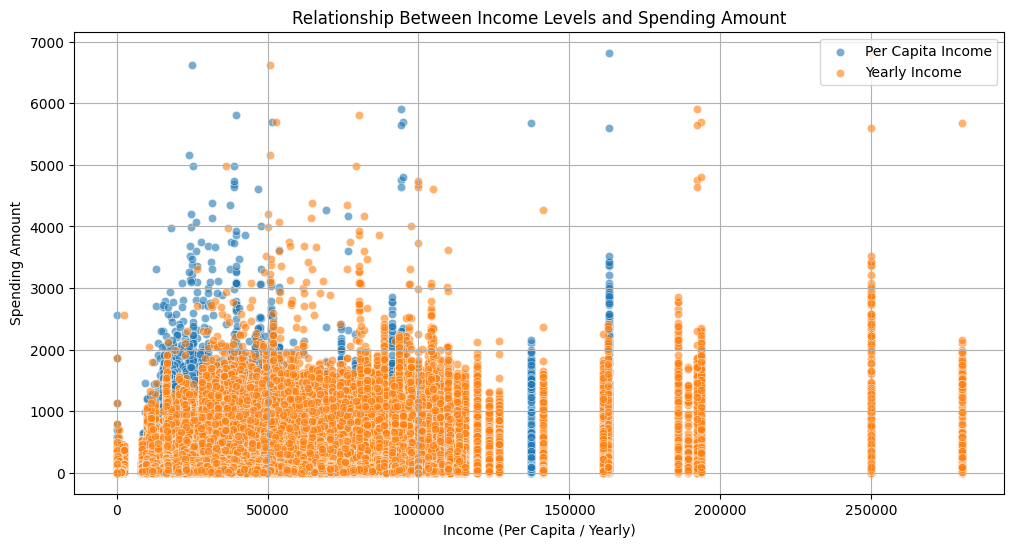

In [14]:
# Step 1: 데이터 병합
# client_id와 id를 기준으로 데이터 병합
user_transactions = transactions.merge(users, left_on='client_id', right_on='id', how='inner')

# 병합 결과 확인
print("Sample of Merged DataFrame:\n", user_transactions.head())

# Step 2: 소득과 소비 간 상관관계 분석
# 상관관계 행렬 계산
correlation_matrix = user_transactions[['amount', 'per_capita_income', 'yearly_income']].corr()
print("Correlation between Income and Spending:\n", correlation_matrix)

# Step 3: 소득 수준별 소비 패턴 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(data=user_transactions, x='per_capita_income', y='amount', alpha=0.6, label='Per Capita Income')
sns.scatterplot(data=user_transactions, x='yearly_income', y='amount', alpha=0.6, label='Yearly Income')
plt.title('Relationship Between Income Levels and Spending Amount')
plt.xlabel('Income (Per Capita / Yearly)')
plt.ylabel('Spending Amount')
plt.legend()
plt.grid()
plt.show()

### 분석 결과

#### 1. 상관관계 분석 결과

##### 상관관계 행렬
| 변수               | amount | per_capita_income | yearly_income |
|--------------------|--------|-------------------|---------------|
| **amount**         | 1.0000 | 0.1316            | 0.1296        |
| **per_capita_income** | 0.1316 | 1.0000            | 0.9486        |
| **yearly_income**  | 0.1296 | 0.9486            | 1.0000        |

##### 해석
1. **소득과 소비 간의 약한 상관관계**:
   - `amount`(소비 금액)과 `per_capita_income`(1인당 소득) 간의 상관계수는 **0.1316**으로, 약한 양의 상관관계.
   - `amount`와 `yearly_income`(연 소득) 간 상관계수는 **0.1296**으로, 1인당 소득과 비슷한 수준으로 약한 양의 상관관계.

2. **1인당 소득과 연 소득 간의 강한 상관관계**:
   - `per_capita_income`과 `yearly_income` 간 상관계수는 **0.9486**으로 매우 강한 양의 상관관계.
   - 이는 1인당 소득과 연 소득이 서로 밀접히 연관되어 있다는 점을 보여줌.

---

#### 2. 그래프 해석

##### 소득과 소비 간의 시각적 패턴
1. **소득 수준별 소비 금액 분포**:
   - **낮은 소득 구간**에서 소비 금액이 고르게 분포하며, 약간의 높은 소비 금액(이상치)을 포함.
   - **중간 소득 구간(50,000~100,000)**에서도 소비 금액이 일정하게 분포되어 있으며, 이 구간에서 소비 금액이 가장 집중.
   - **높은 소득 구간(150,000 이상)**에서는 소비 금액의 분포가 드문드문 나타나며, 고소득자 중 일부만 소비 금액이 큰 패턴을 보임.

2. **소득 증가에 따른 소비의 한계**:
   - 소득이 증가함에 따라 소비 금액의 분포가 넓어지기는 하지만, 소비 금액이 급격히 증가하는 경향은 보이지 않음.
   - 이는 사람들이 소득 증가에 따라 소비를 무한히 늘리기보다는 일정 수준에서 소비를 유지하는 경향이 있음을 시사.

3. **소득 구간별 소비 편차**:
   - 중간 소득 구간에서는 소비 금액의 변동 폭이 크며, 이는 중산층이 다양한 소비 패턴을 보일 가능성을 나타냄.
   - 고소득 구간에서는 소비 금액이 특정 값에 집중되어 있어, 소비 패턴이 상대적으로 단순할 수 있음을 보여줌.

---

#### 3. 결론 및 인사이트

1. **소득이 소비에 미치는 영향은 제한적**:
   - 소득과 소비 간의 상관관계는 약하지만, 소득 증가가 소비를 다소 증가시키는 경향을 보여줌.
   - 이는 소비가 단순히 소득에 의해서만 결정되지 않으며, 다른 요인(예: 가계 상황, 부채, 문화적 요인 등)이 중요한 역할을 한다는 점을 시사.

2. **고소득자 소비 패턴의 집중화**:
   - 고소득 구간에서 소비 금액 분포가 특정 범위에 집중되는 것은 이들의 소비가 기본적으로 일정 수준 이상을 유지하지만, 추가적인 소비에는 제한이 있음을 보여줌.

3. **정책 및 마케팅 방향**:
   - 중간 소득 계층에서 다양한 소비 패턴이 관찰되므로, 이들을 대상으로 한 맞춤형 소비 지원 및 마케팅 전략이 효과적일 것으로 예상됨.
   - 고소득자 소비를 타겟팅할 경우, 높은 소비를 유도할 수 있는 고급 제품 또는 서비스에 초점을 맞출 필요가 있음.


#4. 소비 트렌드 예측 모델
- **Random Forest Regressor 모델링**:
  - 월별 소비 데이터를 기반으로 모델을 학습.
  - 모델 성능 평가(MSE)와 주요 피처의 중요도 분석.
  
- **소비 예측**:
  - 향후 월별 소비 패턴을 예측하여 소비 트렌드를 예측.

Sample of Merged DataFrame:
       id_x                 date  client_id  card_id  amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  -77.00   
1  7475328  2010-01-01 00:02:00        561     4575   14.57   
2  7475329  2010-01-01 00:02:00       1129      102   80.00   
3  7475331  2010-01-01 00:05:00        430     2860  200.00   
4  7475332  2010-01-01 00:06:00        848     3915   46.41   

            use_chip  merchant_id merchant_city merchant_state      zip  ...  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  ...   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  ...   
2  Swipe Transaction        27092         Vista             CA  92084.0  ...   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  ...   
4  Swipe Transaction        13051       Harwood             MD  20776.0  ...   

   birth_month  gender                   address  latitude  longitude  \
0            7  Female  594 Mountain V

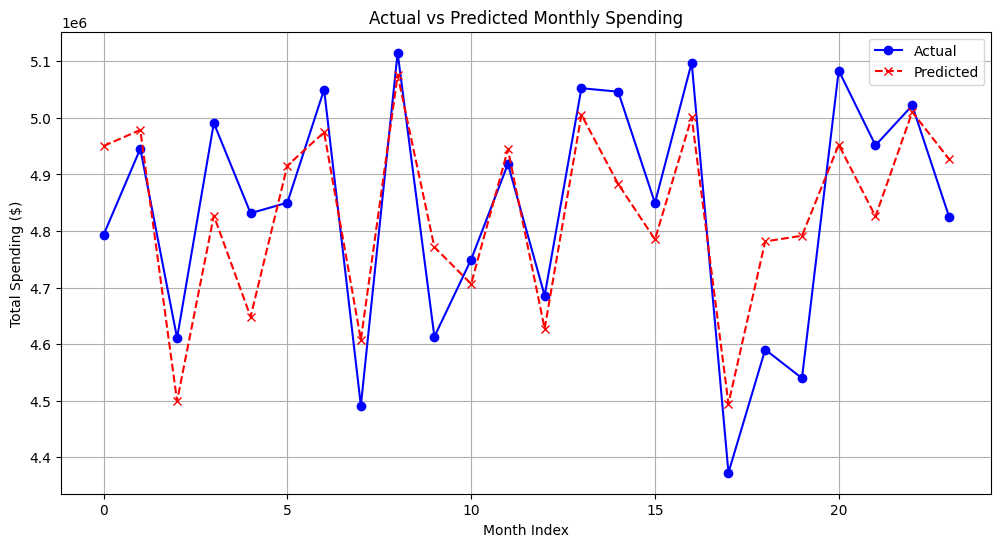

In [8]:
# client_id와 id를 기준으로 데이터 병합
user_transactions = transactions.merge(users, left_on='client_id', right_on='id', how='inner')

# 병합 결과 확인
print("Sample of Merged DataFrame:\n", user_transactions.head())

# 월별 소비 데이터 준비
monthly_data = user_transactions.copy()
monthly_data['date'] = pd.to_datetime(monthly_data['date'])  # 날짜를 datetime 형식으로 변환
monthly_data['year_month'] = monthly_data['date'].dt.to_period('M')  # 연-월 생성

# 월별 소비 금액 집계
monthly_aggregated = monthly_data.groupby('year_month')['amount'].sum().reset_index()
monthly_aggregated['year_month'] = monthly_aggregated['year_month'].astype(str)
monthly_aggregated['year'] = pd.to_datetime(monthly_aggregated['year_month']).dt.year
monthly_aggregated['month'] = pd.to_datetime(monthly_aggregated['year_month']).dt.month

# 입력(X)과 출력(Y) 정의
X = monthly_aggregated[['year', 'month']]
y = monthly_aggregated['amount']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#  모델 평가
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

#  결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(range(len(y_test)), y_pred, label='Predicted', linestyle='--', marker='x', color='red')
plt.title('Actual vs Predicted Monthly Spending')
plt.xlabel('Month Index')
plt.ylabel('Total Spending ($)')
plt.legend()
plt.grid()
plt.show()


##모델 형성 및 분석 결과

### 1. 데이터 샘플
- `user_transactions` 데이터프레임은 거래 데이터(`transactions`)와 사용자 프로필 데이터(`users`)를 성공적으로 병합되었음.
- 병합된 데이터는 총 **26개의 열**로 구성, 다음과 같은 정보를 포함:
  - 거래 관련 정보: `client_id`, `amount`, `merchant_city`, `date` 등.
  - 사용자 프로필 정보: `per_capita_income` (1인당 소득), `yearly_income` (연간 소득), `credit_score` (신용 점수) 등.
- 이를 통해 소비와 소득 간의 관계를 분석할 수 있는 데이터 기반이 마련됨.

---

### 2. Mean Squared Error (MSE)
- 모델 성능 평가 결과:
  - **Mean Squared Error (MSE): 14,810,514,602.857584**
  - 높은 MSE 값은 월별 소비 금액(`amount`)의 스케일이 큰 것이 원인으로 보임.
---

### 3. 그래프 분석
- **실제 값(Actual)**과 **예측 값(Predicted)**의 비교:
  - 전반적으로 **예측 값**이 실제 값의 패턴을 따라가고 있으나, 특정 구간에서 오차가 발생함.
  - 일부 월에서는 예측 값이 실제 값보다 높거나 낮은 경향이 관찰되었습니다.
- **오차 원인**:
  - 개개인마다 월별 소비 데이터의 변동성이 크기 때문에 모델이 이를 완벽히 학습하지 못한 것으로 보임.
  - 데이터 내 이상치(outliers)나 노이즈(noise)의 존재 가능성도 있음.
  -- 하지만 소득 수준에 따라 지출할 수 있는 1일 한도 금액이 다르기 때문에 섣불리 이상치를 판단할 수 없다는 어려움이 있음

---

# 결론 및 활용 방안

## 1. 월별 소비 트렌드 예측
- **소비 증감 패턴 기반의 캠페인**:
  - **증가 시점**: 월별 소비가 급증할 것으로 예측되는 시점(예: 휴가철, 블랙프라이데이)에는 적극적인 할인 프로모션, 마케팅 캠페인을 진행.
  - **감소 시점**: 소비가 감소할 것으로 보이는 시점(예: 비수기)에는 고객 재방문 유도를 위한 쿠폰, 포인트 적립 등 고객 충성도 프로그램 강화.

- **재고 및 서비스 최적화**:
  - 예측된 소비 데이터를 기반으로 특정 시점에 필요한 재고량을 사전에 준비하거나, 서비스 제공 인력을 효율적으로 배치.

- **지역별 맞춤형 지원**:
  - 소비가 높은 지역에 추가적인 가맹점을 유치하거나, 인프라를 확충.
  - 소비가 낮은 지역에서는 소비 촉진을 위한 특별 혜택 제공.

---

## 2. 소득 수준과 소비 간 관계를 기반으로 한 맞춤 전략
- **고소득층 대상 프리미엄 서비스 제공**:
  - 연 소득과 1인당 소득이 높은 세그먼트를 대상으로 고급 상품이나 서비스를 개발.
  - 맞춤형 프리미엄 멤버십, VIP 이벤트를 기획.

- **저소득층 대상의 효율적인 소비 제안**:
  - 소득 대비 가성비 좋은 제품 및 서비스를 추천.
  - 예산 관리 애플리케이션, 할인 쿠폰 제공, 지역 소상공인 제품과 연계한 소비 캠페인 진행.

- **소득 데이터와 소비 패턴에 따른 세그먼트 마케팅**:
  - 소득 수준별 소비 성향을 반영하여 고객 세그먼트를 재구성.
  - 광고와 마케팅 메시지를 고객 세그먼트에 맞게 조정하여 효율성 극대화.

---

## 3. 모델 활용을 통한 장기적인 소비 트렌드 대응
- **장기적인 수익 예측 및 계획 수립**:
  - 월별 소비 데이터를 활용하여 1년 이상의 장기적인 매출 및 수익 예측.
  - 기업의 자원 배분 및 투자 계획에 반영.

- **위험 지역 식별 및 대책 마련**:
  - 소비가 낮고 환불 비율이 높은 지역을 사전 식별하여 대책 마련.
  - 이러한 지역에는 운영 비용을 줄이거나, 맞춤형 소비 증대 전략을 적용.

- **환불 데이터 활용**:
  - 환불 비율이 높은 업종과 지역을 분석하여 문제 해결 방안을 모색.
  - 제품 품질 향상, 고객 서비스 개선, 환불 정책 개정 등을 추진.

---

## 4. 미래 소비 예측으로부터 얻는 비즈니스 인사이트
- **신규 가맹점 위치 추천**:
  - 소비가 지속적으로 증가하는 지역을 식별하고 신규 가맹점 또는 창업 지원을 유도.

- **시장 진출 시기 결정**:
  - 소비가 증가하는 시점에 맞춰 신제품 출시 및 마케팅을 집중적으로 배치.

- **업종 다각화**:
  - 특정 업종에서 소비 증가가 예상되는 경우 새로운 상품 카테고리 또는 서비스를 추가.

---

## 5. 정책 및 공공기관 활용
- **소비 활성화 정책 설계**:
  - 지역별, 업종별 소비 데이터를 기반으로 지방자치단체가 세금 감면 정책, 보조금 정책 설계.
  - 저소득 지역의 소비 촉진을 위한 캠페인 및 공공 지원 확대.

- **도시 계획 및 인프라 개발**:
  - 소비량과 소득 데이터를 기반으로 특정 지역의 상권 활성화, 교통망 개선 등 도시 개발 계획 수립.

---

## 기대 효과
- **기업**: 소비 트렌드 기반의 데이터 중심 의사결정을 통해 매출 증대 및 비용 절감.
- **정부 및 공공기관**: 지역 불균형 해소 및 경제 활성화를 위한 정책 도출.
- **소비자**: 소비 패턴에 맞춘 맞춤형 서비스와 혜택 제공으로 만족도 향상.
